In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

Импортируем данные которые на сделал парсер

In [ ]:
df = pd.read_excel('concat_data.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12510 entries, 0 to 12509
Data columns (total 3 columns):
 #   Column                                                                                         Non-Null Count  Dtype 
---  ------                                                                                         --------------  ----- 
 0   Ежемесячный отчет по совокупному фактическому потреблению электрической энергии в субъекте РФ  12456 non-null  object
 1   Unnamed: 1                                                                                     12460 non-null  object
 2   Unnamed: 2                                                                                     12410 non-null  object
dtypes: object(3)
memory usage: 293.3+ KB


После парсинга данные надо обработать и убрать лишни строки, присвоить нормальные имена столбцам

In [ ]:
# Переименовываем столбцы
df = df.rename(columns={'Ежемесячный отчет по совокупному фактическому потреблению электрической энергии в субъекте РФ': 'date', 'Unnamed: 1': 'hour', 'Unnamed: 2': 'consumption'})

удалим строки с Nan это позволит нам избавиться от тех строк после парсинга данных где были указаны названия столбцов от каждой таблицы

In [ ]:
df = df.dropna()

Удаляем из первого столбца строку с значением 1, так это строка применялась для обозначения порядкового нмоера столбца из данных после парсинга

In [ ]:
df = df[df['date'] != 1]

In [ ]:
# Преобразуем столбец 'date' в тип datetime
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

<ipython-input-10-bd3c38014adf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')


In [ ]:
# Сбрасываем индексацию и восстанавливаем порядок индексов
df = df.reset_index(drop=True)

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['hour'] = pd.to_timedelta(df['hour'], unit='h')
df['new_date'] = df['date'] + df['hour']

In [ ]:
# Удаляем столбец 'date'
df = df.drop('date', axis=1)

In [ ]:
# Удаляем столбец 'hour'
df = df.drop('hour', axis=1)

Проверим количество отсутствующих строк данных, по возможности востановим их

In [ ]:
# Преобразуум столбец 'new_date' в формат даты
df['new_date'] = pd.to_datetime(df['new_date'])

# Создадим DataFrame с последовательными датами
min_date = df['new_date'].min()
max_date = df['new_date'].max()
sequence_dates = pd.date_range(start=min_date, end=max_date, freq='H')
sequence_df = pd.DataFrame({'sequence_date': sequence_dates})

# Объединим исходный DataFrame с последовательными датами
merged_df = pd.merge(sequence_df, df, left_on='sequence_date', right_on='new_date', how='left')


print("Исходные данные с последовательными датами:")
print(merged_df[['consumption', 'sequence_date']])

# Находим пропущенные даты
missing_dates = merged_df[merged_df['consumption'].isna()]['sequence_date']

print("\nПропущенные даты:")
print(missing_dates)

Исходные данные с последовательными датами:
      consumption       sequence_date
0        3860.564 2021-10-01 01:00:00
1        3856.057 2021-10-01 02:00:00
2        3870.914 2021-10-01 03:00:00
3        3951.075 2021-10-01 04:00:00
4        4078.359 2021-10-01 05:00:00
...           ...                 ...
18259    4645.252 2023-10-31 20:00:00
18260    4520.692 2023-10-31 21:00:00
18261    4311.215 2023-10-31 22:00:00
18262    4191.804 2023-10-31 23:00:00
18263    4133.159 2023-11-01 00:00:00

[18264 rows x 2 columns]

Пропущенные даты:
24      2021-10-02 01:00:00
25      2021-10-02 02:00:00
26      2021-10-02 03:00:00
27      2021-10-02 04:00:00
28      2021-10-02 05:00:00
                ...        
18211   2023-10-29 20:00:00
18212   2023-10-29 21:00:00
18213   2023-10-29 22:00:00
18214   2023-10-29 23:00:00
18215   2023-10-30 00:00:00
Name: sequence_date, Length: 5904, dtype: datetime64[ns]


5904 строки пропущенных значений

В датасете merged_df Получаем все строки до часа, вместо отсутствующих значений consumption подставляем NaN, создаем дополнительный столбик с указанием date полного с каждым часом, и опираясь на это будет востанавливать данные

Все пусты значения я решил востановить двигаясь на 24 строки назад, тоесть на сутки, с помощью этого мы сможем заполнить данные особо не вредя

In [ ]:
count = 0

# Запустим цикл, пока есть NaN значения в столбце "consumption"
while merged_df['consumption'].isna().any():
    merged_df['consumption'] = merged_df['consumption'].fillna(merged_df['consumption'].shift(24))
    count += 1

print("Количество итераций:", count)

Количество итераций: 10


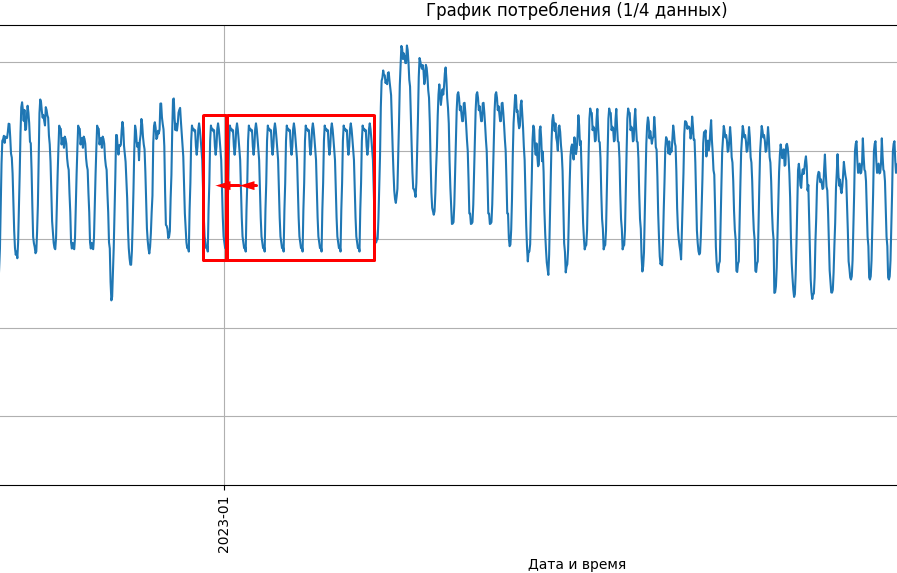

Сделаем визуализацию потребления за 2 года

In [ ]:
# Установим столбец 'date_time' как индекс
merged_df.set_index('sequence_date', inplace=True)

In [ ]:
import matplotlib.dates as mdates

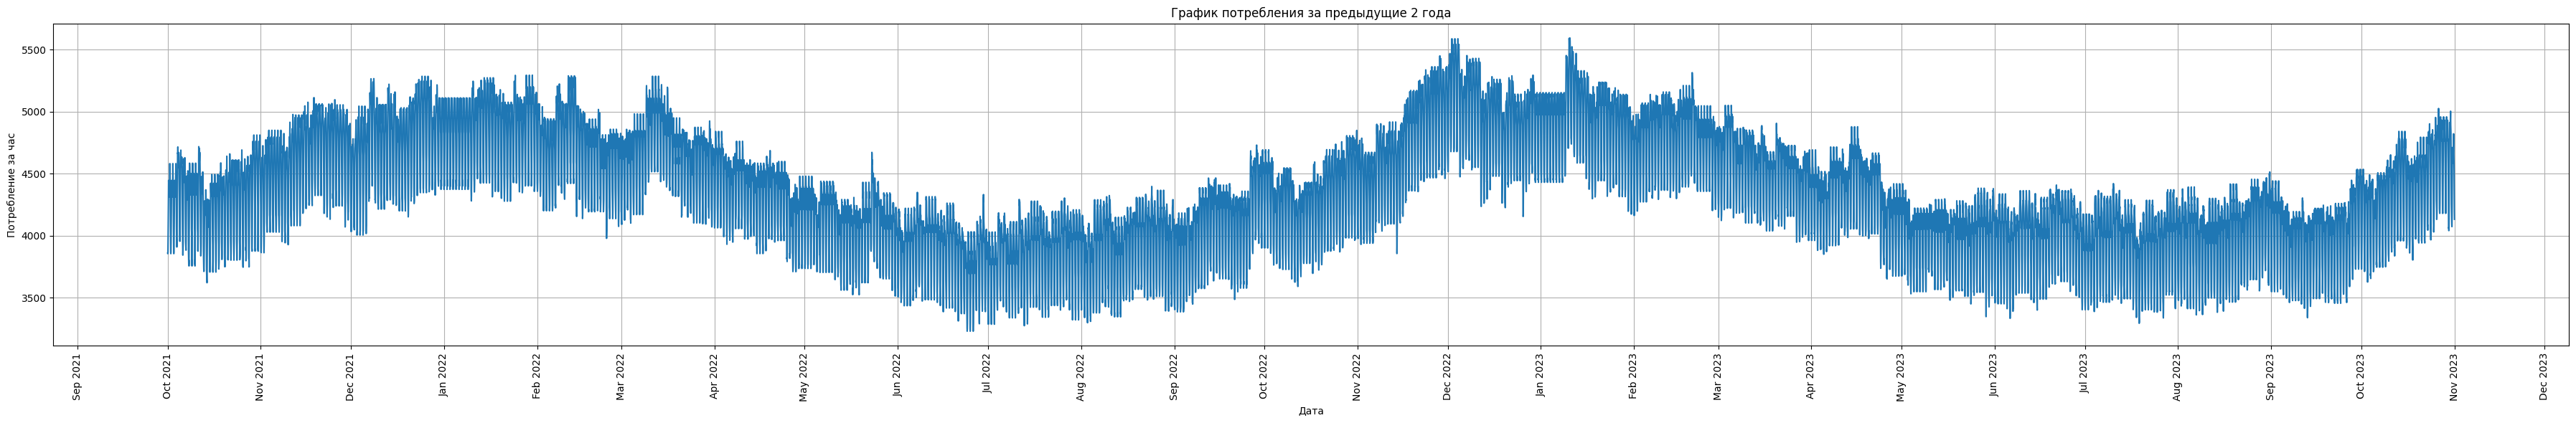

In [ ]:
# Построим график для выбранной четверти данных
plt.figure(figsize=(36, 6))
plt.plot(merged_df.index, merged_df['consumption'], linestyle='-')
plt.title('График потребления за предыдущие 2 года')
plt.xlabel('Дата')
plt.ylabel('Потребление за час')
plt.grid(True)

# Создаем форматер даты для месяцев
date_format = mdates.DateFormatter('%b %Y')

# Установим деления на оси X с помощью форматера даты для месяцев
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(date_format)

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

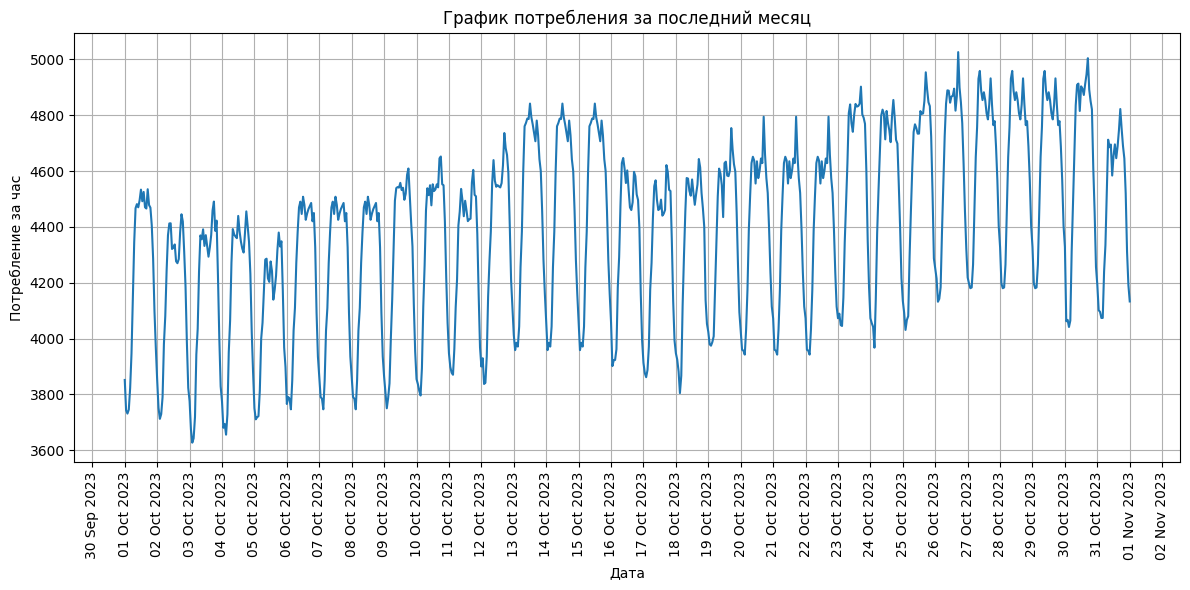

In [ ]:
# Дата начала последнего месяца в данных
last_month_start = pd.Timestamp.now() - pd.DateOffset(months=1)
last_month_start = last_month_start.replace(day=1, hour=0, minute=0, second=0, microsecond=0)

# срез данных только за последний месяц
last_month_df = merged_df[last_month_start:]

# график для последнего месяца данных
plt.figure(figsize=(12, 6))
plt.plot(last_month_df.index, last_month_df['consumption'], linestyle='-')
plt.title('График потребления за последний месяц')
plt.xlabel('Дата')
plt.ylabel('Потребление за час')
plt.grid(True)

# форматер даты для дней месяца и года
date_format = mdates.DateFormatter('%d %b %Y')

# деления на оси X с помощью форматера даты
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(date_format)

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [ ]:
# Возвращаем индекс 'new_date'
merged_df.reset_index(inplace=True)

In [ ]:
merged_df

,sequence_date,consumption,new_date
0,2021-10-01 01:00:00,3860.564,2021-10-01 01:00:00
1,2021-10-01 02:00:00,3856.057,2021-10-01 02:00:00
2,2021-10-01 03:00:00,3870.914,2021-10-01 03:00:00
3,2021-10-01 04:00:00,3951.075,2021-10-01 04:00:00
4,2021-10-01 05:00:00,4078.359,2021-10-01 05:00:00
...,...,...,...
18259,2023-10-31 20:00:00,4645.252,2023-10-31 20:00:00
18260,2023-10-31 21:00:00,4520.692,2023-10-31 21:00:00
18261,2023-10-31 22:00:00,4311.215,2023-10-31 22:00:00
18262,2023-10-31 23:00:00,4191.804,2023-10-31 23:00:00


In [ ]:
# Удаляем столбец 'new_date'
merged_df = merged_df.drop('new_date', axis=1)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18264 entries, 0 to 18263
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sequence_date  18264 non-null  datetime64[ns]
 1   consumption    18264 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 285.5 KB


Преобразуем sequence_date в datetime и установим индекс

In [ ]:
merged_df['sequence_date'] = pd.to_datetime(merged_df['sequence_date'])
merged_df.set_index('sequence_date', inplace=True)

In [ ]:
merged_df

,consumption
sequence_date,
2021-10-01 01:00:00,3860.564
2021-10-01 02:00:00,3856.057
2021-10-01 03:00:00,3870.914
2021-10-01 04:00:00,3951.075
2021-10-01 05:00:00,4078.359
...,...
2023-10-31 20:00:00,4645.252
2023-10-31 21:00:00,4520.692
2023-10-31 22:00:00,4311.215


In [ ]:
# индекс 'new_date'
merged_df.reset_index(inplace=True)

In [ ]:
print(merged_df)

            sequence_date  consumption
0     2021-10-01 01:00:00     3860.564
1     2021-10-01 02:00:00     3856.057
2     2021-10-01 03:00:00     3870.914
3     2021-10-01 04:00:00     3951.075
4     2021-10-01 05:00:00     4078.359
...                   ...          ...
18259 2023-10-31 20:00:00     4645.252
18260 2023-10-31 21:00:00     4520.692
18261 2023-10-31 22:00:00     4311.215
18262 2023-10-31 23:00:00     4191.804
18263 2023-11-01 00:00:00     4133.159

[18264 rows x 2 columns]


После обработки пустых проверим еще раз

In [ ]:
df_filled = merged_df

In [ ]:
# DataFrame с последовательными датами
min_date = df_filled['sequence_date'].min()
max_date = df_filled['sequence_date'].max()
sequence_dates = pd.date_range(start=min_date, end=max_date, freq='H')
sequence_df = pd.DataFrame({'sequence_date': sequence_dates})

# Объединяем исходный DataFrame с последовательными датами
merged_df = pd.merge(sequence_df, df_filled, left_on='sequence_date', right_on='sequence_date', how='left')

print("Исходные данные с последовательными датами:")
print(merged_df[['consumption', 'sequence_date']])

missing_dates = merged_df[merged_df['consumption'].isna()]['sequence_date']

print("\nПропущенные даты:")
print(missing_dates)

Исходные данные с последовательными датами:
       consumption       sequence_date
0         3860.564 2021-10-01 01:00:00
1         3856.057 2021-10-01 02:00:00
2         3870.914 2021-10-01 03:00:00
3         3951.075 2021-10-01 04:00:00
4         4078.359 2021-10-01 05:00:00
...            ...                 ...
18259     4645.252 2023-10-31 20:00:00
18260     4520.692 2023-10-31 21:00:00
18261     4311.215 2023-10-31 22:00:00
18262     4191.804 2023-10-31 23:00:00
18263     4133.159 2023-11-01 00:00:00

[18264 rows x 2 columns]

Пропущенные даты:
Series([], Name: sequence_date, dtype: datetime64[ns])


Теперь пропущенных значений нет

In [ ]:
# Проверка стационарности
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_filled['consumption'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.908100
p-value: 0.328260


- data - будем диффиренцировать
- df_filled - оставим как есть

In [ ]:
data = df_filled

In [ ]:
# Выполняем дифференцирование (первую разность)
data['consumption_diff'] = data['consumption'].diff()

In [ ]:
data

,sequence_date,consumption,consumption_diff
0,2021-10-01 01:00:00,3860.564,NaN
1,2021-10-01 02:00:00,3856.057,-4.507
2,2021-10-01 03:00:00,3870.914,14.857
3,2021-10-01 04:00:00,3951.075,80.161
4,2021-10-01 05:00:00,4078.359,127.284
...,...,...,...
18259,2023-10-31 20:00:00,4645.252,-44.645
18260,2023-10-31 21:00:00,4520.692,-124.560
18261,2023-10-31 22:00:00,4311.215,-209.477
18262,2023-10-31 23:00:00,4191.804,-119.411


In [ ]:
# Заполнить NaN-значения нулями
data['consumption_diff'].fillna(0, inplace=True)

In [ ]:
#data['consumption'] = data['consumption'].fillna(data['consumption'].mean())
# Тут заполнял средними но мне это не подходит, заменил на 0

In [ ]:
# Проверка данных на наличие nan или inf
print("Есть ли NaN в данных:", data['consumption_diff'].isna().any())
print("Есть ли inf в данных:", np.isinf(data['consumption_diff']).any())

Есть ли NaN в данных: False
Есть ли inf в данных: False


In [ ]:
data.set_index('sequence_date', inplace=True)

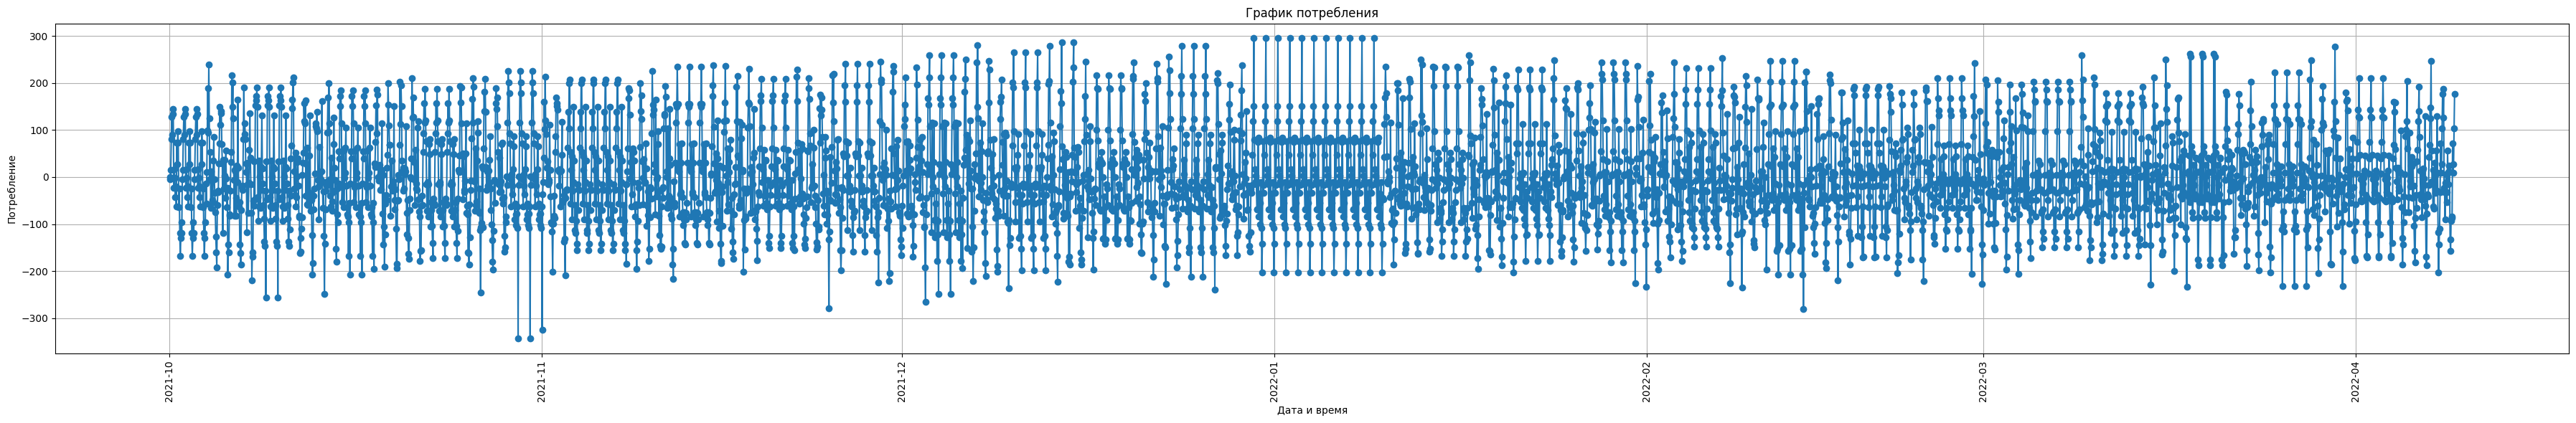

In [ ]:
quarter_data = data.iloc[:int(len(data) * 0.25)]
# Построим график
plt.figure(figsize=(36, 6))
plt.plot(quarter_data.index, quarter_data['consumption_diff'], marker='o', linestyle='-')
plt.title('График потребления')
plt.xlabel('Дата и время')
plt.ylabel('Потребление')
plt.grid(True)
# Подпишем индексы снизу вертикально
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

Теперь проверим на стационарность

In [ ]:
# Проверка стационарности
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['consumption'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.908100
p-value: 0.328260


результаты теста Дики-Фуллера (ADF) после дифференцирования данных показывают значительные изменения:

ADF Statistic: -6.219838: Это значение значительно ниже пороговых значений, обычно используемых для определения стационарности (например, -3.5, -2.9, -2.6 в зависимости от размера выборки и уровня уверенности). Чем меньше значение (то есть чем более отрицательное), тем меньше вероятность наличия единичного корня в ряде, что указывает на стационарность.

p-value: 0.000000: Это значение близко к нулю, что гораздо меньше порога 0.05, обычно используемого для определения статистической значимости. Это означает, что нулевая гипотеза о наличии единичного корня (нестационарности) ряда может быть уверенно отвергнута

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.8 MB/s eta 0:00:00


Сократим датасет для автоподбора параметров обучения

In [ ]:
middle_index = len(data) // 48
# Создаем новый датасет, содержащий только первую половину данных
reduced_data = data.iloc[:middle_index]

In [ ]:
# Подбор параметров ARIMA
import pmdarima as pm
model = pm.auto_arima(reduced_data['consumption'], seasonal=True, m=24,
                      d=1, D=1, max_p=5, max_q=5, trace=True,
                      error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[24]             : AIC=inf, Time=32.88 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=3658.571, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=3627.590, Time=1.56 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=3601.195, Time=7.57 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=3658.667, Time=0.52 sec
 ARIMA(0,1,1)(1,1,1)[24]             : AIC=inf, Time=6.36 sec
 ARIMA(0,1,1)(0,1,2)[24]             : AIC=inf, Time=16.36 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=3627.546, Time=0.93 sec
 ARIMA(0,1,1)(1,1,2)[24]             : AIC=inf, Time=13.17 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=3602.550, Time=1.57 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=3600.786, Time=7.00 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=inf, Time=1.16 sec
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=14.70 sec
 ARIMA(1,1,1)(0,1,2)[24]             : AIC=inf, Time=27.09 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=inf, T

In [ ]:
data2 = data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18264 entries, 2021-10-01 01:00:00 to 2023-11-01 00:00:00
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   consumption       18264 non-null  float64
 1   consumption_diff  18264 non-null  float64
dtypes: float64(2)
memory usage: 428.1 KB


In [ ]:
# Отделение последних 24 часов для тестирования
train = data.iloc[:-24]
test = data.iloc[-24:]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18264 entries, 2021-10-01 01:00:00 to 2023-11-01 00:00:00
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   consumption       18264 non-null  float64
 1   consumption_diff  18264 non-null  float64
dtypes: float64(2)
memory usage: 428.1 KB


In [ ]:
# Обучение модели ARIMA
model_fit = model.fit(train['consumption_diff'])

In [ ]:
# Прогнозирование
forecast = model_fit.predict(n_periods=24)  # Прогноз на 24 часа вперёд

In [ ]:
# Прогнозирование на первые 24 часа
forecast_2 = model_fit.predict(n_periods=len(forecast)+24)

In [ ]:
forecast_2 = forecast_2[-24:]

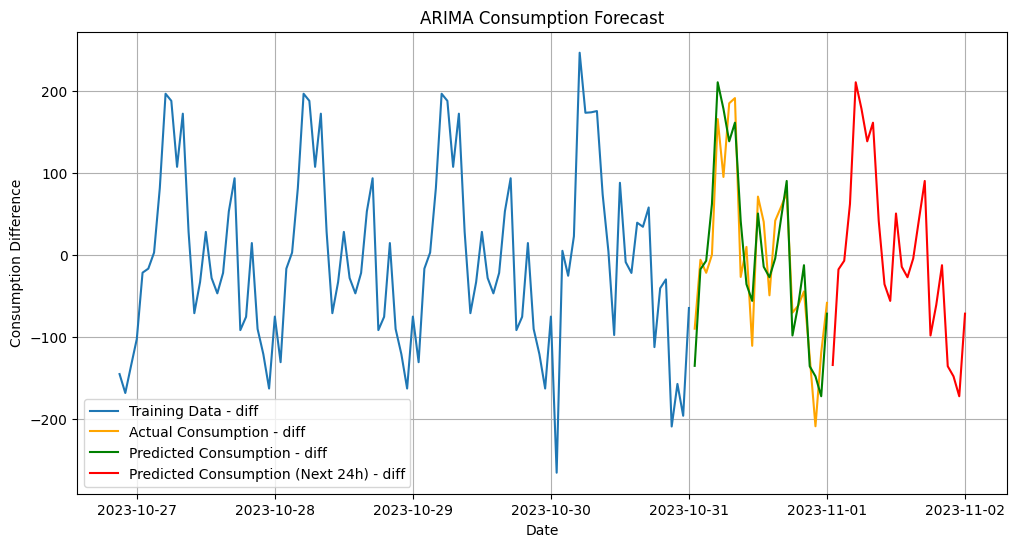

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.index[-100:], train['consumption_diff'][-100:], label='Training Data - diff')
plt.plot(test.index, test['consumption_diff'], label='Actual Consumption - diff', color='orange')
plt.plot(test.index, forecast, label='Predicted Consumption - diff', color='green')
plt.plot(test.index + pd.to_timedelta(24, unit='h'), forecast_2, label='Predicted Consumption (Next 24h) - diff', color='red')
plt.title('ARIMA Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Consumption Difference')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

# Оценка модели
mse = mean_squared_error(test['consumption_diff'], forecast)
print(f"Средняя квадратичная ошибка (MSE): {mse}")
rmse = sqrt(mse)
print(f"RMSE: {rmse}")
r2 = r2_score(test['consumption_diff'], forecast)
print(f"Коэффициент детерминации (R^2): {r2}")
mae = mean_absolute_error(test['consumption_diff'], forecast)
print(f"Средняя абсолютная ошибка (MAE): {mae}")



Средняя квадратичная ошибка (MSE): 1802.244690528815
RMSE: 42.45285256056199
Коэффициент детерминации (R^2): 0.817780150372702
Средняя абсолютная ошибка (MAE): 36.68842006869249


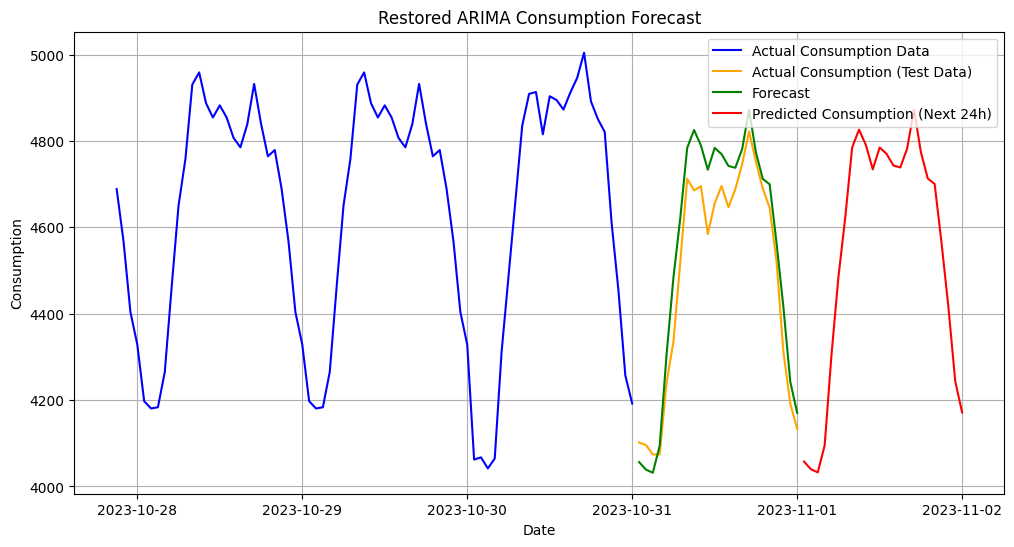

In [ ]:
# Восстановление исходных значений на основе дифференцированных предсказаний
last_known_value = data['consumption'].iloc[-24 - 1]  # Последнее известное значение перед прогнозом
cumulative_forecast = last_known_value + forecast.cumsum()
cumulative_forecast_2 = last_known_value + forecast_2.cumsum()
# Подготовка графика
plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:-24], data['consumption'][-100:-24], label='Actual Consumption Data', color='blue')
plt.plot(test.index, data['consumption'][-24:], label='Actual Consumption (Test Data)', color='orange')
plt.plot(test.index, cumulative_forecast, label='Forecast', color='green')
plt.plot(test.index + pd.to_timedelta(24, unit='h'), cumulative_forecast_2, label='Predicted Consumption (Next 24h)', color='red')
plt.title('Restored ARIMA Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
cumulative_forecast_2

2023-11-01 01:00:00    4057.407063
2023-11-01 02:00:00    4039.692288
2023-11-01 03:00:00    4032.562577
2023-11-01 04:00:00    4094.911551
2023-11-01 05:00:00    4305.908121
2023-11-01 06:00:00    4484.446155
2023-11-01 07:00:00    4623.276189
2023-11-01 08:00:00    4784.894449
2023-11-01 09:00:00    4826.412019
2023-11-01 10:00:00    4790.581498
2023-11-01 11:00:00    4734.338755
2023-11-01 12:00:00    4784.937739
2023-11-01 13:00:00    4770.413645
2023-11-01 14:00:00    4743.094558
2023-11-01 15:00:00    4738.794432
2023-11-01 16:00:00    4782.401684
2023-11-01 17:00:00    4872.771702
2023-11-01 18:00:00    4774.267543
2023-11-01 19:00:00    4713.098361
2023-11-01 20:00:00    4700.512646
2023-11-01 21:00:00    4564.416513
2023-11-01 22:00:00    4415.978454
2023-11-01 23:00:00    4243.174866
2023-11-02 00:00:00    4171.345066
Freq: H, dtype: float64

In [ ]:
data['consumption'][-100:-24].to_csv("data_actual.csv", index=True)

In [ ]:
data['consumption'][-24:].to_csv("data_actual_test.csv", index=True)

In [ ]:
# Преобразование Series в DataFrame
cumulative_forecast_df = cumulative_forecast.to_frame()
cumulative_forecast_df.columns = ['consumption']
cumulative_forecast_df.index.name = 'sequence_date'
cumulative_forecast_df.to_csv("cumulative_forecast.csv", index=True)

In [ ]:
# Преобразование Series в DataFrame
cumulative_forecast_2_df = cumulative_forecast_2.to_frame()
# Присвоение названий столбцам
cumulative_forecast_2_df.index.name = 'sequence_date'
cumulative_forecast_2_df.columns = ['consumption']
cumulative_forecast_2_df.to_csv("cumulative_forecast_2.csv", index=True)

In [ ]:
data2.reset_index(inplace=True)

In [ ]:
data2.set_index('sequence_date', inplace=True)

In [ ]:
# Группировка по месяцам и суммирование значений потребления
monthly_consumption = data2['consumption'].resample('M').sum().to_frame(name='consumption')

In [ ]:
monthly_consumption = monthly_consumption.iloc[:-1]

In [ ]:
monthly_consumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2021-10-31 to 2023-10-31
Freq: M
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  25 non-null     float64
dtypes: float64(1)
memory usage: 400.0 bytes


In [ ]:
monthly_consumption

,consumption
sequence_date,
2021-10-31,3184081.508
2021-11-30,3329577.193
2021-12-31,3548456.869
2022-01-31,3616619.293
2022-02-28,3157954.677
2022-03-31,3474850.202
2022-04-30,3124341.062
2022-05-31,3042855.606
2022-06-30,2798516.020


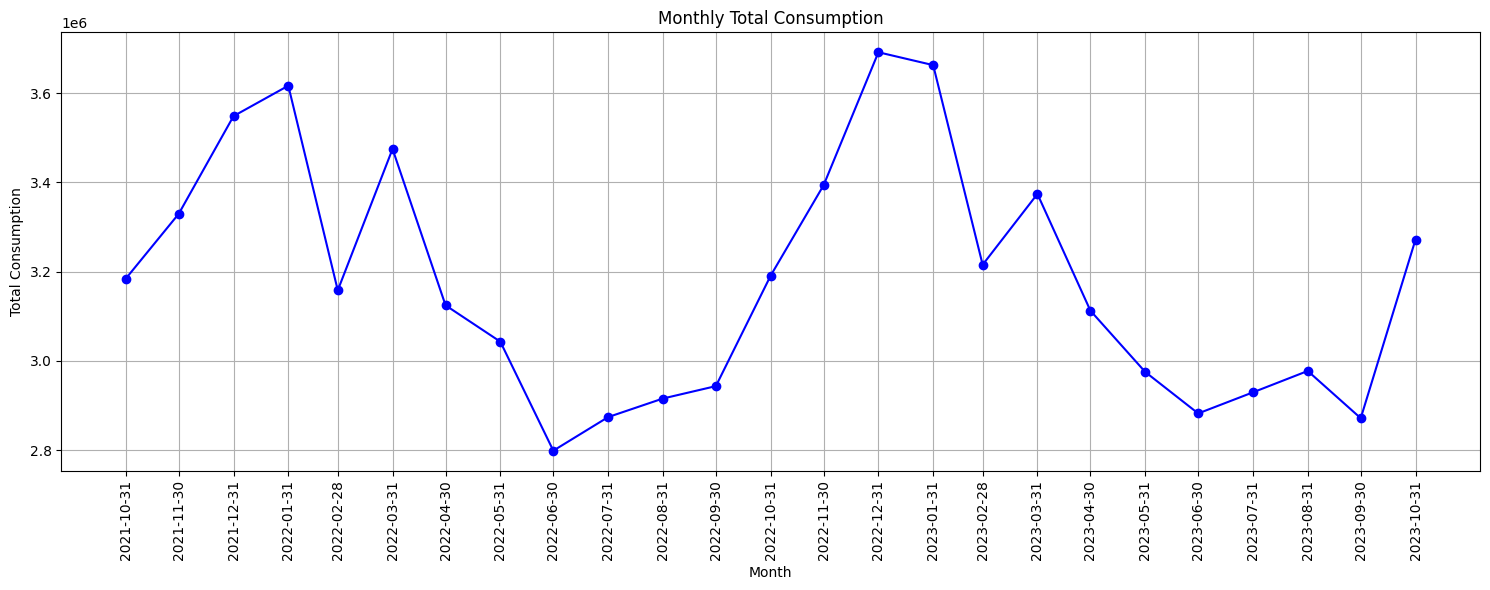

In [ ]:
# Построение графика без аннотаций
plt.figure(figsize=(15, 6))
plt.plot(monthly_consumption.index, monthly_consumption['consumption'], marker='o', color='blue')
plt.title('Monthly Total Consumption')
plt.xlabel('Month')
plt.ylabel('Total Consumption')
plt.grid(True)
plt.xticks(monthly_consumption.index, rotation=90)  # Поворачиваем метки на 90 градусов
plt.tight_layout()  # Автоматическое корректирование расположения элементов
plt.show()

In [ ]:
del model

In [ ]:
del model_fit

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator

Новая модель

Такая ХХХ попробуй сгенерить на 2 месяца а потом разделить, 1 месяц будет тестовый его и предскажешь и акутальные данные на него наложишь, я спать

In [ ]:
# Отделение последнего месяца для тестирования
train_df = monthly_consumption[:-1]
test_df = monthly_consumption[-1:]

Старые данные

In [ ]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_df)

# Создание последовательностей для обучения модели LSTM
n_input = 3  # Количество временных шагов (например, 3 месяца)К
n_features = 1  # Количество признаков (в данном случае 1 - потребление)
generator = TimeseriesGenerator(scaled_data, scaled_data, length=n_input, batch_size=1)

# Создание модели LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
history = model.fit(generator, epochs=200)

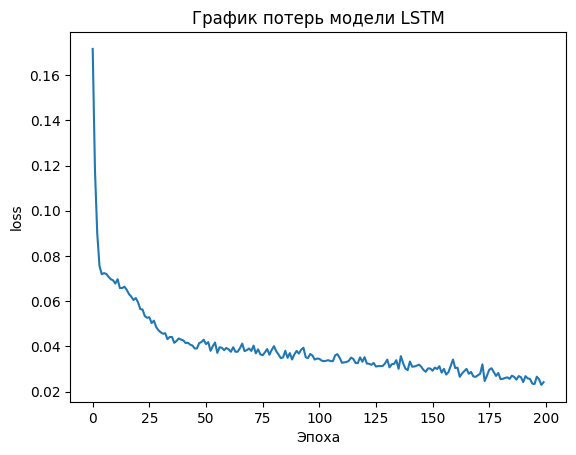

In [ ]:
plt.plot(history.history['loss'])
plt.title('График потерь модели LSTM')
plt.ylabel('loss')
plt.xlabel('Эпоха')
plt.show()

In [ ]:
# Подготовка тестовых данных и прогнозирование
test_data = scaled_data[-(n_input + 1):]  # Последние данные для теста
test_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=1)
predictions = model.predict(test_generator)

# Обратное преобразование прогноза
predicted_consumption = scaler.inverse_transform(predictions)

# Оценка модели
true_consumption = test_df['consumption'].values[-len(test_df):]

1/1 [==============================] - 0s 54ms/step


In [ ]:
test_df

,consumption
sequence_date,
2023-10-31,3271833.021


In [ ]:
# Расчет MSE
mse = np.mean((np.array(true_consumption) - np.array(predicted_consumption)) ** 2)

# Расчет RMSE
rmse = np.sqrt(mse)

# Расчет MAE
mae = np.mean(np.abs(np.array(true_consumption) - np.array(predicted_consumption)))

print(f'mse = {mse}')
print(f'rmse = {rmse}')
print(f'mae = {mae}')

mse = 22582657074.123497
rmse = 150275.27100000018
mae = 150275.27100000018


In [ ]:
# Создайте DataFrame с индексами следующего месяца
next_month_index = train_df.index[-1] + pd.DateOffset(months=1)
predicted_consumption_df = pd.DataFrame(index=[next_month_index])

# Добавьте столбец с предсказанными значениями в новый DataFrame
predicted_consumption_df['consumption'] = predicted_consumption.flatten()

# Выведите результат
print(predicted_consumption_df)

            consumption
2023-10-30   3121557.75


In [ ]:
print(train_df.index)
print(test_df.index)
print(predicted_consumption_df.index)


DatetimeIndex(['2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30'],
              dtype='datetime64[ns]', name='sequence_date', freq='M')
DatetimeIndex(['2023-10-31'], dtype='datetime64[ns]', name='sequence_date', freq='M')
DatetimeIndex(['2023-10-30'], dtype='datetime64[ns]', freq=None)


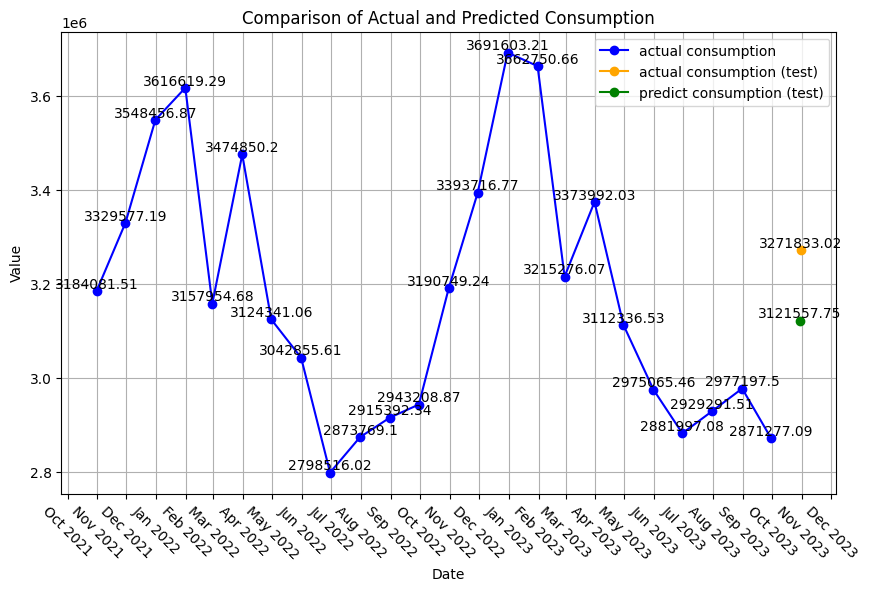

In [ ]:
# Создание графика
plt.figure(figsize=(10, 6))

# График для актуального потребления
plt.plot(train_df.index, train_df['consumption'], label='actual consumption', color='blue', marker='o')
plt.plot(test_df.index, test_df['consumption'], label='actual consumption (test)', color='orange', marker='o')
plt.plot(predicted_consumption_df.index, predicted_consumption_df['consumption'], label='predict consumption (test)', color='green', marker='o')

# Настройка меток времени
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Добавление сетки
plt.grid(True)

# Настройка графика
plt.title('Comparison of Actual and Predicted Consumption')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=-45)

# Добавление легенды
plt.legend()

# Добавление значений к каждой точке
for i, value in enumerate(train_df['consumption']):
    plt.text(train_df.index[i], value, str(round(value, 2)), ha='center', va='bottom')
for i, value in enumerate(test_df['consumption']):
    plt.text(test_df.index[i], value, str(round(value, 2)), ha='center', va='bottom')
for i, value in enumerate(predicted_consumption_df['consumption']):
    plt.text(predicted_consumption_df.index[i], value, str(round(value, 2)), ha='center', va='bottom')

# Отображение графика
plt.show()

In [ ]:
train_df.index

DatetimeIndex(['2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30'],
              dtype='datetime64[ns]', name='sequence_date', freq='M')

In [ ]:
# Преобразование DataFrame в массив NumPy
data = df['consumption'].values.reshape(-1, 1)

# Масштабирование данных в диапазон [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Создание последовательных временных рядов
look_back = 3  # Вы можете изменить это значение в зависимости от вашего выбора
X, y = [], []

for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:(i + look_back), 0])
    y.append(data_scaled[i + look_back, 0])

X, y = np.array(X), np.array(y)

# Изменение формы данных для LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Создание LSTM модели
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Обучение модели
model.fit(X, y, epochs=100, batch_size=1)

# Создание тестового набора данных для предсказания будущих периодов
test_data = data_scaled[-look_back:].reshape(1, -1, 1)

# Предсказание будущих периодов
prediction = model.predict(test_data)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))

# Вывод предсказания
print(f'Прогноз на следующий месяц: {prediction_inverse[0, 0]}')

Epoch 1/100
22/22 [==============================] - 4s 6ms/step - loss: 0.1843
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0888
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0846
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0817
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0808
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0815
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0791
Epoch 8/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0808
Epoch 9/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0802
Epoch 10/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0784
Epoch 11/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0805
Epoch 12/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0779
Epoch 13/100
22/22 [===============

In [ ]:
# Преобразование DataFrame в массив NumPy
data = df['consumption'].values.reshape(-1, 1)

# Масштабирование данных в диапазон [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Создание последовательных временных рядов
look_back = 3
X, y = [], []

for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:(i + look_back), 0])
    y.append(data_scaled[i + look_back, 0])

X, y = np.array(X), np.array(y)

# Изменение формы данных для LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Создание LSTM модели
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Обучение модели
model.fit(X, y, epochs=100, batch_size=1)

# Создание тестового набора данных для предсказания будущих периодов
test_data = data_scaled[-look_back:].reshape(1, -1, 1)

# Предсказание будущих периодов
predictions = []

for i in range(12):  # Предсказание на 12 месяцев вперед (можете изменить этот параметр)
    prediction = model.predict(test_data)
    predictions.append(prediction[0, 0])
    test_data = np.roll(test_data, -1)
    test_data[-1, -1, 0] = prediction[0, 0]

# Инвертирование масштабирования
predictions_inverse = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

Epoch 1/100
22/22 [==============================] - 4s 7ms/step - loss: 0.1565
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0928
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0844
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0849
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0878
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0806
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0800
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0799
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0808
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0789
Epoch 11/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0789
Epoch 12/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0901
Epoch 13/100
22/22 [=================

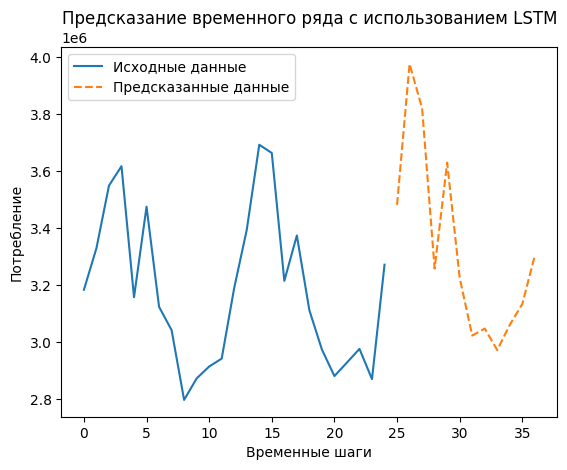

In [ ]:
# Получение исходных данных (немасштабированных)
original_data = df['consumption'].values

# Создание временных шагов для графика
time_steps = range(len(original_data))

# Построение графика исходных данных
plt.plot(time_steps, original_data, label='Исходные данные')

# Создание временных шагов для предсказанных данных
future_time_steps = range(len(original_data), len(original_data) + len(predictions))

# Построение графика предсказанных данных
plt.plot(future_time_steps, predictions_inverse, label='Предсказанные данные', linestyle='dashed')

# Настройка легенды и осей
plt.legend()
plt.xlabel('Временные шаги')
plt.ylabel('Потребление')
plt.title('Предсказание временного ряда с использованием LSTM')

# Отображение графика
plt.show()

Epoch 1/100
22/22 [==============================] - 5s 6ms/step - loss: 0.1843
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0860
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0870
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0840
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0865
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0945
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0838
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0796
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0827
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0794
Epoch 11/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0795
Epoch 12/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0809
Epoch 13/100
22/22 [=================

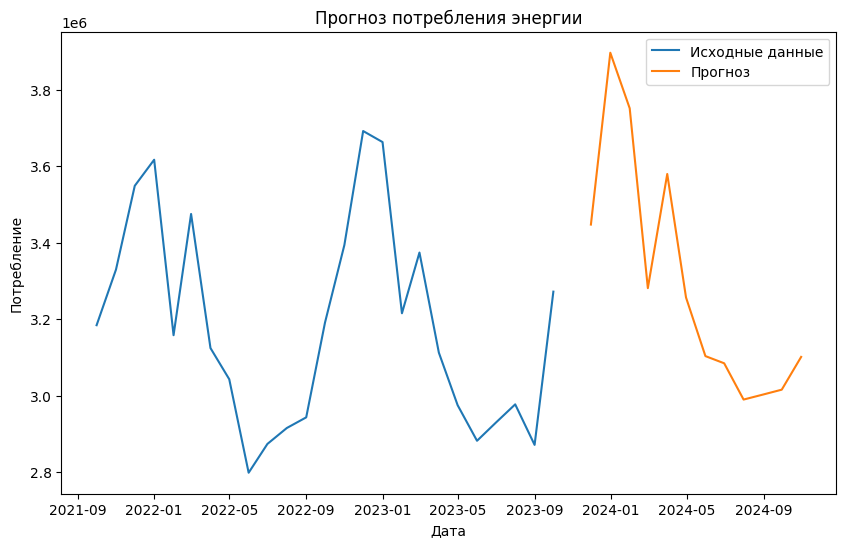

In [ ]:
# Преобразование DataFrame в массив NumPy
data = df['consumption'].values.reshape(-1, 1)

# Масштабирование данных в диапазон [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Создание последовательных временных рядов
look_back = 3
X, y = [], []

for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:(i + look_back), 0])
    y.append(data_scaled[i + look_back, 0])

X, y = np.array(X), np.array(y)

# Изменение формы данных для LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Создание LSTM модели
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Обучение модели
model.fit(X, y, epochs=100, batch_size=1)

# Создание тестового набора данных для предсказания будущих периодов
test_data = data_scaled[-look_back:].reshape(1, -1, 1)

# Предсказание будущих периодов
predictions = []

for i in range(12):  # Предсказание на 12 месяцев вперед (можете изменить этот параметр)
    prediction = model.predict(test_data)
    predictions.append(prediction[0, 0])
    test_data = np.roll(test_data, -1)
    test_data[-1, -1, 0] = prediction[0, 0]

# Инвертирование масштабирования
predictions_inverse = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Преобразование столбца 'Month' в тип datetime
df['Month'] = pd.to_datetime(df['Month'].astype(str))

# Создание временного индекса для графика
date_index = pd.date_range(start=df['Month'].iloc[-1], periods=13, freq='M')[1:]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['consumption'], label='Исходные данные')
plt.plot(date_index, predictions_inverse, label='Прогноз')
plt.title('Прогноз потребления энергии')
plt.xlabel('Дата')
plt.ylabel('Потребление')
plt.legend()
plt.show()

Epoch 1/100
22/22 [==============================] - 4s 4ms/step - loss: 0.1976
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0965
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0878
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0818
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0870
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0844
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0884
Epoch 9/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0815
Epoch 10/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0817
Epoch 11/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0824
Epoch 12/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0782
Epoch 13/100
22/22 [=================

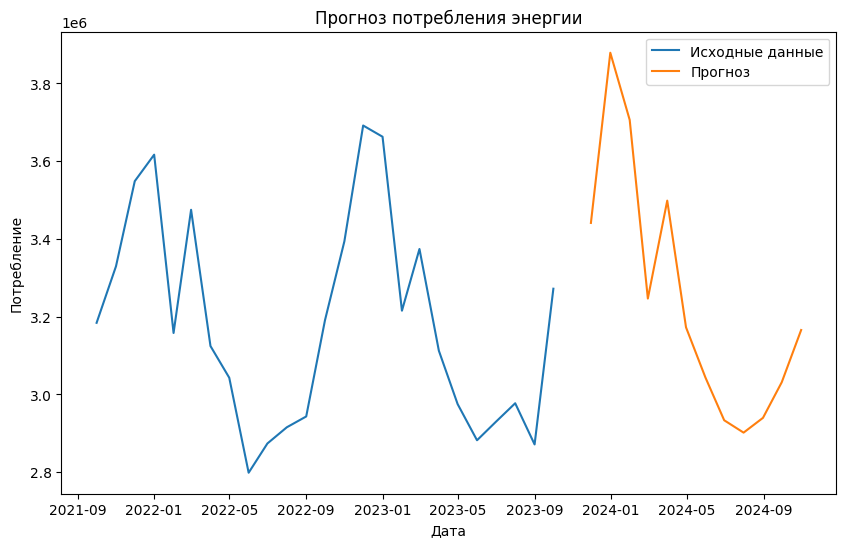

In [ ]:
# Преобразование DataFrame в массив NumPy
data = df['consumption'].values.reshape(-1, 1)

# Масштабирование данных в диапазон [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Создание последовательных временных рядов
look_back = 3
X, y = [], []

for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:(i + look_back), 0])
    y.append(data_scaled[i + look_back, 0])

X, y = np.array(X), np.array(y)

# Изменение формы данных для LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Создание LSTM модели
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Обучение модели
model.fit(X, y, epochs=100, batch_size=1)

# Создание тестового набора данных для предсказания будущих периодов
test_data = data_scaled[-look_back:].reshape(1, -1, 1)

# Предсказание будущих периодов
predictions = []

for i in range(12):  # Предсказание на 12 месяцев вперед (можете изменить этот параметр)
    prediction = model.predict(test_data)
    predictions.append(prediction[0, 0])
    test_data = np.roll(test_data, -1)
    test_data[-1, -1, 0] = prediction[0, 0]

# Инвертирование масштабирования
predictions_inverse = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Преобразование столбца 'Month' в тип datetime
df['Month'] = pd.to_datetime(df['Month'].astype(str))

# Создание временного индекса для графика
date_index = pd.date_range(start=df['Month'].iloc[-1], periods=13, freq='M')[1:]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['consumption'], label='Исходные данные')
plt.plot(date_index, predictions_inverse, label='Прогноз')
plt.title('Прогноз потребления энергии')
plt.xlabel('Дата')
plt.ylabel('Потребление')
plt.legend()
plt.show()